# <center>Practical 06 Coding Exercises: Robot Control</center>

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as linalg
import pickle

from Practical06_Support.Robot import *
from Practical06_Support.Robot1D import *
from Practical06_Support.Helper import *
from Practical06_Support.Renderer import Renderer as PenguinPiRenderer
from Practical06_Support.Renderer1D import RobotRenderer

## Exercise 1 (3 pts): Implement a Pose Controller for the PenguinPi Robot

In Part 2 of practical notebook, we defined a proportional controller that brings our PenguinPi Robot to a desired location in space. However, we did not control the robot's orientation.

Your task is to implement the ``MoveToGoalPoseController``, which brings our robot to a goal pose that includes a desired orientation $(x_g, y_g, \theta_g)$. 

**Hints**
- The ``Helper.py`` contains many helpful functions you may need, use them as necessary.
- Such as ``get_distance_robot_to_goal Compute(.)``, which compute distance between two points,
- and ``clamp_angle(.)`` which limits range of angle to the range $[-\pi, \pi]$

In [3]:
class MoveToPoseController(object):
    
    """A simple move to pose proportional controller"""
    def __init__(self, robot=None):
        """
        Initialize a new move to pose proportional controller
        :param robot: The robotic system to controlled
        :param K_a: A proportional gain, you could add more as necessary
        """
        self.robot = robot
        
    def run(self, goal_position=np.zeros(3), delta_time=0.01):
        """
        Run control loop until the robot reaches the goal_position
        :param goal_position: Desired goal position
        :returns: Tuple of arrays. A 3DxN array for the system states and a 2DxN array for control inputs
        """
        
        states = []
        controls = []
        initial_state = self.robot.get_state()
        states.append(initial_state)
        
        stop_criteria_met = False
        
        #TODO 1: Add control parameters here -----------------------------------------
        K_pv = 1
        K_pw = 10
        K_pPose = 2
        dist_threshold = 0.01
        angle_threshold = 0.01
        iteration_threshold = 10000
        i = 0
        #ENDTODO ---------------------------------------------------------------------
        
        #TODO 2: Compute errors such as distance towards goal position ---------------
        dist_error = get_distance_robot_to_goal(initial_state,goal_position)
        init_dist_error = dist_error
        angle_error = clamp_angle(get_angle_robot_to_goal(initial_state,goal_position))
        pose_error = clamp_angle(initial_state[2] - goal_position[2])
        #ENDTODO ---------------------------------------------------------------------
        while not stop_criteria_met: 
            
            #TODO 3: Compute the new control input -----------------------------------
            i = i + 1
            v_k = K_pv * dist_error
            w_k = K_pw * angle_error + K_pPose * pose_error * abs(1-dist_error/init_dist_error)
            #ENDTODO -----------------------------------------------------------------
            
            # Apply control to robot
            self.robot.drive(v_k, w_k, delta_time)
            new_state = self.robot.get_state()
            
            # Keep track of variables for plotting
            controls.append([v_k, w_k])
            states.append(new_state)
                        
            #TODO 4: Update errors ---------------------------------------------------
            dist_error = get_distance_robot_to_goal(states[-1],  goal_position)
            angle_error = clamp_angle(get_angle_robot_to_goal(states[-1], goal_position))
            pose_error = clamp_angle(states[-1][2] - goal_position[2])
            #ENDTODO -----------------------------------------------------------------
            #TODO 5: Check for stopping criteria -------------------------------------
            if (dist_error < dist_threshold and pose_error < angle_threshold) or i > iteration_threshold:
            #ENDTODO -----------------------------------------------------------------
                stop_criteria_met = True
            
                       
        return np.array(states), np.array(controls)

### Test your Solution

**Visually**: The position and orientation of your robot should match the target pose currently displayed as a fixed 2D coordinate frame at (1.5, 0.0)

**Evaluation**: ``dist_travel`` and ``pose_difference`` are computed for you

Distance travelled is:  [4.51609]
Pose error is:  [9.68351814e-08 7.44172945e-10 9.97986241e-03]


Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=1769),…

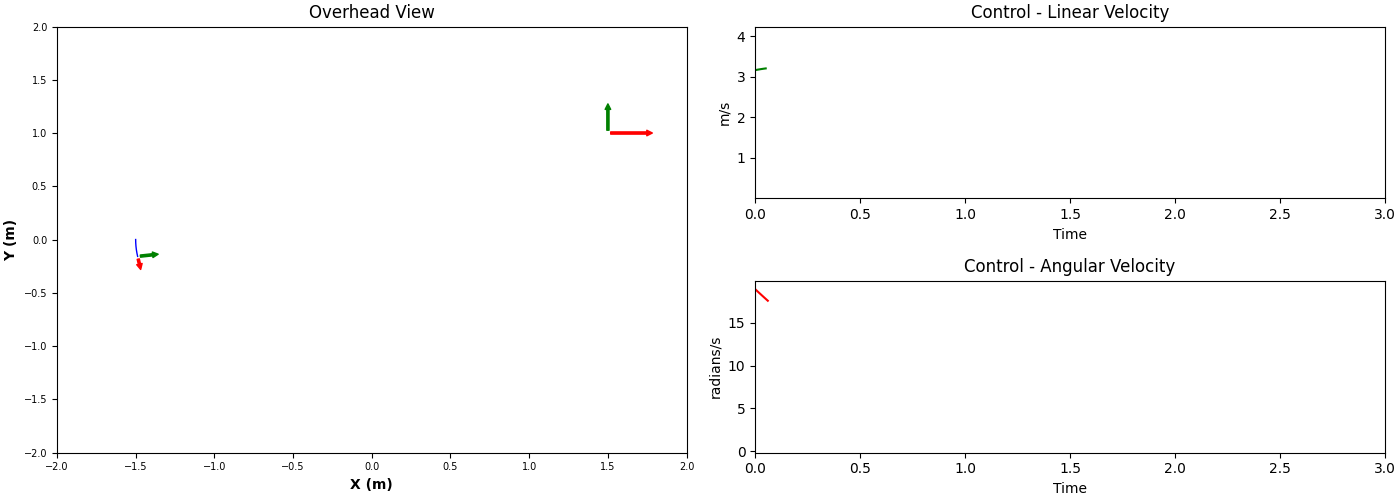

In [4]:
# Define robot, desired goal and delta time
start_pose = np.array([-1.5, 0.0, -np.pi/2])
desired_goal = np.array([1.5, 1.0, 0])
delta_t = 0.01
bot = PenguinPi(init_state=start_pose)

# Instantiate controller and compute sequence of control signal
controller = MoveToPoseController(bot)
robot_states, robot_controls = controller.run(goal_position=desired_goal, delta_time=delta_t)

#================== Do not change this part=======================================#
# Evaluation of your implementation
dist_travel = sum((np.power(robot_states[1:-1,0:2]-robot_states[0:-2,0:2],2) @ np.ones([2,1]))**0.5)
pose_error = abs(robot_states[-1,:] - desired_goal)
#=================================================================================#
print('Distance travelled is: ', dist_travel)
print('Pose error is: ', pose_error)

# Define renderer and start animation
rend = PenguinPiRenderer.Instance()
rend.initialize(robot_states, robot_controls, target_pose=desired_goal, dt_data=delta_t)

## Exercise 2 (3 pts): Implement a Discrete Time Finite Horizon LQR Controller

The solution to the discrete-time finite horizon LQR problem is given by the following algorithm:

1. Set $P_N$ = Q
2. For $t = N,\dots,1$

<center>$P_{t-1} = Q + A^TP_tA - A^TP_tB(R+B^TP_tB)^{-1}B^TP_tA$</center>

3. For $t = 0,\dots,N-1$, define
<center>$K_{t} = -(R+B^TP_{t+1}B)^{-1}B^TP_{t+1}A$</center>

4. For $t = 0,\dots,N-1$, optimal $\mathbf{u}_t$ is given by <center>$\mathbf{u}_t = K_t(\mathbf{x}_t - \mathbf{x}_g$)</center>

You are tasked with defining the corresponding ``DiscreteFiniteLQR`` Python class. A skeleton class is provided below. 

**Please keep in mind**
- ``self.P`` = $[P_1, P_2,\dots,P_N]$. Each time you compute a new P matrix, add it to the self.P attribute (defined as a list) using the method ``self.P.append(new_P)``. All P matrices are needed for the computation of the gains.
- ``self.K`` = $[K_0, K_1,\dots,K_{N-1}]$. Each time you compute a new gain K, add it to the self.K attribute (defined as a list) using the method ``self.K.append(new_K)``. All K matrices are needed for the computation of the control inputs.

In [152]:
class DiscreteFiniteLQR(object):
    
    """A simple LQR controller."""

    def __init__(self, Q=np.eye(2), R=0.3):
        
        """
        Initialize a new LQR controller.
        :param Q: State cost
        :param R: Control cost
        """
        
        self.Q = Q
        self.R = R
        
        # List of solutions to the Riccati Equation for each iteration
        self.P = []
        # List of controller gains for each iteration
        self.K = []
        
        
    def solve(self, system, horizon=20):
        
        """
        Compute controller gain for a given system
        :param system: Linear system for which a control law needs to be
                       computed
        :param horizon: Planning horizon
        """
        
        A = system.A
        B = system.B
        
        # Set P_N = Q
        self.P.append(self.Q)
        
        #TODO 1: Compute all P matrices ------------------------------------------
        # Append each new P matrix to the class attribute self.P
        for i in range(horizon):
            new_P = Q + A.T @ self.P[0] @ A - A.T @ self.P[0] @ B @ linalg.inv(R + B.T @ self.P[0] @ B) @ B.T @ self.P[0] @ A
            self.P.insert(0, new_P)
        #ENDTODO -----------------------------------------------------------------
        
        #TODO 2: Compute all gains K  --------------------------------------------
        # Append each new K gain to the class attribute self.K
        for i in range(horizon):
            new_K = -linalg.inv(R + B.T @ self.P[i] @ B) @ B.T @ self.P[i] @ A
            self.K.append(new_K)
         #ENDTODO ----------------------------------------------------------------
            
                
    def run_control_loop(self, system, desired_state, horizon):
        """
        Compute control inputs required for the system to reach the desired state
        :param system: Linear system for which a control inputs need to be
                       computed
        :param desired_state: Target state for the system
        :param horizon: Planning horizon
        :returns: Tuple of arrays, 1Dxhorizon array for the system outputs (i.e., position) and 1Dxhorizon array for control inputs
        """
         
        u_controls, y_outputs = [], []

        for i in range(horizon):
            
            #TODO 3: Compute control inputs -------------------------------------------
            #Hint system would be the Robot1D model seen in practical notebook
            # Get current state for computation of control u_t
            print(bot.get_state())
            x_t_0 = bot.get_state()[0]
            print(x_t_0)
            x_t_1 = bot.get_state()[1]
            x_t_2 = bot.get_state()[2]
            
            # Get system's output
            print(system.C[0,:])
            y_t = system.C[0,:] @ x_t_0

            # Compute control u_t
            u_t = (self.K[i][0]) @ (x_t - desired_state)
            
            # and apply control to the robot
            bot.drive(u_t)
            #ENDTODO -----------------------------------------------------------------
            
            # Add values to return types
            u_controls += [u_t]
            y_outputs += [y_t]
             
        
        return np.array(y_outputs), np.array(u_controls)
    

### Test Your Solution

Compute $\mathbf{u}_t$ and $\mathbf{y}_t$ using the gains obtained from your LQR controller. You can test your output against the values stored in the test files ``lqr_test.pk``.

Your implementation will be compared against another set of test cases for grading

In [153]:
# Load test case and define variables
with open('Practical06_Support/pickle/lqr_test.pk', 'rb') as read_from:
    test = pickle.load(read_from)

# Create an instance of our system
A=test['A']
B=test['B']
C=test['C']
initial_state=test['initial_state']
print('A', A, '\nB', B, '\nC', C)

my_system = Robot1D(A=A, B=B, C=C, initial_state=initial_state)

# Define the state and control costs as well as the planning horizon
Q = test['Q']
R = test['R']
horizon = test['horizon']
print('Q',Q, '\nR',R, '\nhorizon',horizon)

# Create an instace of our controller and solve the LQR problem
lqr = DiscreteFiniteLQR(Q=Q, R=R)
lqr.solve(my_system, horizon)

# Define desired state
desired_x = test['desired_state']
print('desired_x',desired_x)

# Apply control loop
y_array, u_array = lqr.run_control_loop(my_system, desired_x, horizon)

# Plot and compare results
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(np.arange(horizon), u_array, 'r', label='Your Solution')
ax1.plot(np.arange(horizon), test['control'], 'g-.', label='Expected', lw=2)
ax1.set_ylabel(r'$\mathbf{u}_t$')
ax1.legend(loc='best')

ax2.plot(np.arange(horizon), y_array, 'b', label='Your Solution')
ax2.plot(np.arange(horizon), test['output'], 'g-.', label='Expected', lw=2)
ax2.set_ylabel(r'$\mathbf{y}_t$')
ax2.set_xlabel('Time')
ax2.legend(loc='best')

ax1.set_title('LQR Finite Horizon Control Results')

print('Is control input close to solution? ',np.all(np.isclose(test['control'], u_array)))
print('Is state output close to solution? ',np.all(np.isclose(test['output'], y_array)))

A [[ 1.   0.4  0.   0. ]
 [-0.6  1.   0.4  0. ]
 [ 0.   0.4  1.  -0.6]
 [ 0.   0.   0.4  1. ]] 
B [[1]
 [0]
 [0]
 [0]] 
C [0 0 0 1]
Q [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]] 
R [[1.]] 
horizon 100
desired_x [[0]
 [0]
 [0]
 [0]]
[array([[ 9.57640961e-06, -1.01903458e+01,  1.38171043e+00,
         -1.03528157e+01]])
 array([[0.98502981, 0.88332808, 0.99881945, 0.8817066 ]])
 0.00997986241411608]
[[ 9.57640961e-06 -1.01903458e+01  1.38171043e+00 -1.03528157e+01]]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Grading

## For the Penguinpi Controller:
- Make sure that the ``run(.)`` function returns two arrays. The first array of dimensions 3xN corresponds to states. The second array of dimensions 2XN corresponds to the inputs (or controls) computed by your controller
- Remove all print statements before submitting your solution
- You get 2 points if ``pose_difference`` is smaller than `[0.001, 0.001, 0.23]`
- You get the third point if ``dist_travelled`` is smaller than the example solution

## For LQR exercise:
- You will be graded based on the output of the ``run_control_loop_method(.)``. Please make sure that your solution returns the expected variables with the correct type (no rounding is needed)
- Remove all print statements before submitting your solution
- Discrete LQR is deterministic with a fixed Q, R, A, B and horizon, if your control signal and state matches the solution, you will get full mark which is 3 points, otherwise 0 point

**NOTE**: Penguinpi Exercise might get to infinity loop if you are not careful, if there is a single block in the notebook that leads to infinity loop, you will get 0 for the whole notebook, or even if your infinity loop is dormant (living inside a function that get called during grading, you will also get 0 fro the whole notebook!)

In [43]:
import otter
grader = otter.Notebook(tests_dir = "Practical06_Support/tests")
grader.check_all()

lqr_q1 results:
    lqr_q1 - 1 result:
        Trying:
            import pickle
        Expecting nothing
        ok
        Trying:
            a_file = open("Practical06_Support/pickle/lqr_case1.pk", "rb")
        Expecting nothing
        ok
        Trying:
            data = pickle.load(a_file)
        Expecting nothing
        ok
        Trying:
            A = data["A"]
        Expecting nothing
        ok
        Trying:
            B = data["B"]
        Expecting nothing
        ok
        Trying:
            C = data["C"]
        Expecting nothing
        ok
        Trying:
            desired_state = data["desired_state"]
        Expecting nothing
        ok
        Trying:
            initial_state = data['initial_state']
        Expecting nothing
        ok
        Trying:
            horizon = data["horizon"]
        Expecting nothing
        ok
        Trying:
            Q = data["Q"]
        Expecting nothing
        ok
        Trying:
            R = data["R"]
       